In [1]:
#gerekli kütüphaneleri indiriyoruz
%pip install pandas scikit-learn
%pip install matplotlib
%pip install numpy
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#test ve train setlerimizi import ediyoruz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train = pd.read_csv("evler-train.csv")
test = pd.read_csv("evler-test.csv")

# Veri boyutunu kontrol edelim
print(f"Train samples: {len(train)}")
print(f"Test samples: {len(test)}")
print(f"Features: {train.shape[1] - 2}")  # -2 for evNo and fiyat
print(f"\nTrain/Test ratio: {len(train)/len(test):.2f}")


Train samples: 55
Test samples: 11
Features: 17

Train/Test ratio: 5.00


Verilerin yapısı "evNo,fiyat,brutM2,netM2,oda,salon,yas,kat,katMaks,dogalGaz,banyo,amerikan,balkon,asansor,otopark,esya,siteMi,aidat,guneyMi" şeklinde.

## Veri Seti Hakkında

Bu veri seti, ev fiyat tahminlemesi için 66 ev örneğinden oluşmaktadır (55 eğitim, 11 test). Her ev 17 farklı özellik ile tanımlanmıştır:

**Fiziksel Özellikler:**
- `brutM2`: Brüt metrekare
- `netM2`: Net metrekare
- `oda`: Oda sayısı
- `salon`: Salon sayısı
- `banyo`: Banyo sayısı
- `kat`: Bulunduğu kat
- `katMaks`: Binadaki maksimum kat sayısı
- `yas`: Binanın yaşı

**Konfor Özellikleri:**
- `dogalGaz`: Doğal gaz varlığı (1: var, 0: yok)
- `amerikan`: Amerikan mutfak (1: var, 0: yok)
- `balkon`: Balkon varlığı (1: var, 0: yok)
- `asansor`: Asansör varlığı (1: var, 0: yok)
- `otopark`: Otopark varlığı (1: var, 0: yok)
- `esya`: Eşyalı olup olmadığı (1: evet, 0: hayır)

**Konum ve Site Özellikleri:**
- `siteMi`: Site içinde mi? (1: evet, 0: hayır)
- `aidat`: Aylık aidat miktarı
- `guneyMi`: Güney cepheli mi? (1: evet, 0: hayır)

**Hedef Değişken:**
- `fiyat`: Evin satış fiyatı (tahmin edilecek değer)

In [3]:
#veri ön işleme ile değeri -1 (yani boş) olan verileri, knn kullanarak dolduruyoruz
from sklearn.impute import KNNImputer
import numpy as np

# Convert -1 to NaN so KNN Imputer can recognize them as missing values
train = train.replace(-1, np.nan)
test = test.replace(-1, np.nan)

# Now apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
train = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
test = pd.DataFrame(imputer.transform(test), columns=test.columns)

print("Missing values after imputation:")
print(f"Train: {train.isna().sum().sum()}")
print(f"Test: {test.isna().sum().sum()}")

Missing values after imputation:
Train: 0
Test: 0


In [4]:
# Feature scaling - critical for SVR and can improve other models
from sklearn.preprocessing import StandardScaler

# Separate features and target
X_train = train.drop(columns=["fiyat", "evNo"])
y_train = train["fiyat"]
X_test = test.drop(columns=["fiyat", "evNo"])
y_test = test["fiyat"]

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("Feature scaling completed")
print(f"Train shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")

Feature scaling completed
Train shape: (55, 17)
Test shape: (11, 17)


Orijinal eğitim seti boyutu: 55
SMOTER sonrası: 71 örnek (+16 sentetik)


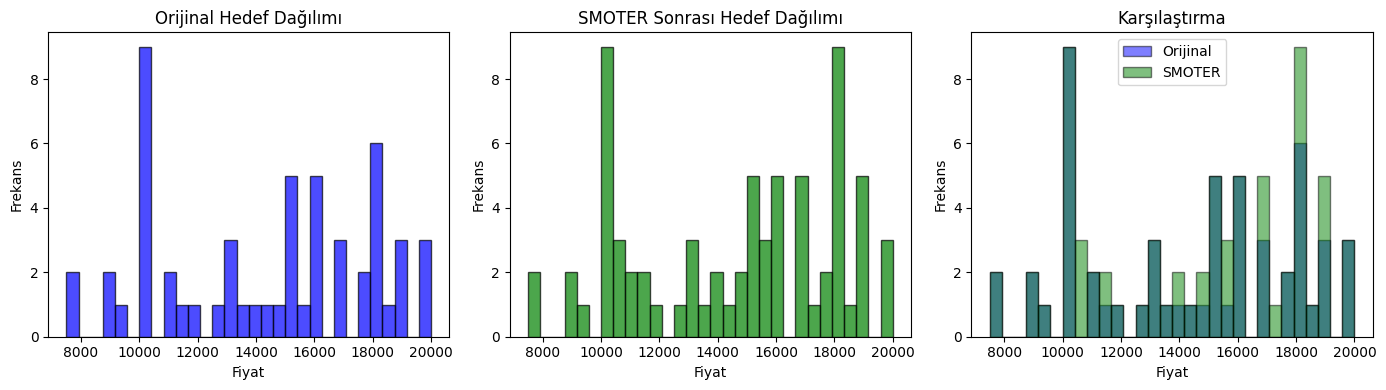


Hedef istatistikleri:
Orijinal - Ortalama: 14300.91, Std. Sapma: 3614.59
SMOTER   - Ortalama: 14545.78, Std. Sapma: 3504.64


In [5]:
# SMOTER Implementation for Regression
# Regresyon için sentetik örnekler oluşturarak veri dengesizliğini giderir
from scipy.spatial.distance import euclidean
import random

def smoter(X, y, k=5, percentage=50):
    """
    SMOTER: Regresyon için SMOTE
    Yetersiz temsil edilen hedef değer aralıkları için sentetik örnekler oluşturur
    
    Parametreler:
    - X: özellikler (DataFrame veya array)
    - y: hedef değerler (Series veya array)
    - k: kullanılacak komşu sayısı
    - percentage: oluşturulacak sentetik örnek yüzdesi (orijinal boyuta göre)
    
    Döndürür:
    - X_resampled, y_resampled
    """
    from sklearn.neighbors import NearestNeighbors
    
    X_array = X.values if hasattr(X, 'values') else X
    y_array = y.values if hasattr(y, 'values') else y
    
    # Hedef değer dağılımına göre nadir bölgeleri belirle
    q25, q75 = np.percentile(y_array, [25, 75])
    iqr = q75 - q25
    
    y_median = np.median(y_array)
    
    # Her örnek için yoğunluğu hesapla
    nbrs = NearestNeighbors(n_neighbors=min(k+1, len(X_array))).fit(X_array)
    distances, indices = nbrs.kneighbors(X_array)
    
    # Komşularına daha uzak olan örnekler seyrek bölgelerdedir
    avg_distances = distances[:, 1:].mean(axis=1)  # Kendisi hariç
    sparse_threshold = np.percentile(avg_distances, 60)
    
    # Seyrek bölgelerdeki örnekleri belirle
    sparse_indices = np.where(avg_distances > sparse_threshold)[0]
    
    n_synthetic = int(len(X_array) * percentage / 100)
    
    X_synthetic = []
    y_synthetic = []
    
    for _ in range(n_synthetic):
        # Seyrek bölgeden rastgele bir örnek seç
        if len(sparse_indices) > 0:
            idx = np.random.choice(sparse_indices)
        else:
            idx = np.random.choice(len(X_array))
        
        # k en yakın komşuyu bul
        distances, neighbor_indices = nbrs.kneighbors([X_array[idx]], n_neighbors=k+1)
        neighbor_indices = neighbor_indices[0][1:]  # Kendisi hariç
        
        # Rastgele bir komşu seç
        nn_idx = np.random.choice(neighbor_indices)
        
        # Sentetik örnek oluştur (interpolasyon)
        alpha = np.random.random()
        X_new = X_array[idx] + alpha * (X_array[nn_idx] - X_array[idx])
        y_new = y_array[idx] + alpha * (y_array[nn_idx] - y_array[idx])
        
        X_synthetic.append(X_new)
        y_synthetic.append(y_new)
    
    # Orijinal ve sentetik örnekleri birleştir
    X_resampled = np.vstack([X_array, np.array(X_synthetic)])
    y_resampled = np.hstack([y_array, np.array(y_synthetic)])
    
    # Giriş DataFrame ise DataFrame'e geri dönüştür
    if hasattr(X, 'columns'):
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    if hasattr(y, 'name'):
        y_resampled = pd.Series(y_resampled, name=y.name)
    
    return X_resampled, y_resampled

# Eğitim verisine SMOTER uygula
print("Orijinal eğitim seti boyutu:", len(X_train))
X_train_smoter, y_train_smoter = smoter(X_train, y_train, k=5, percentage=30)
print(f"SMOTER sonrası: {len(X_train_smoter)} örnek (+{len(X_train_smoter) - len(X_train)} sentetik)")

# Ölçeklendirilmiş versiyon da oluştur
X_train_smoter_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_smoter), 
    columns=X_train.columns
)

# SMOTER'in etkisini görselleştir
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.hist(y_train, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Orijinal Hedef Dağılımı')
plt.xlabel('Fiyat')
plt.ylabel('Frekans')

plt.subplot(1, 3, 2)
plt.hist(y_train_smoter, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('SMOTER Sonrası Hedef Dağılımı')
plt.xlabel('Fiyat')
plt.ylabel('Frekans')

plt.subplot(1, 3, 3)
plt.hist(y_train, bins=30, alpha=0.5, color='blue', label='Orijinal', edgecolor='black')
plt.hist(y_train_smoter, bins=30, alpha=0.5, color='green', label='SMOTER', edgecolor='black')
plt.title('Karşılaştırma')
plt.xlabel('Fiyat')
plt.ylabel('Frekans')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nHedef istatistikleri:")
print(f"Orijinal - Ortalama: {y_train.mean():.2f}, Std. Sapma: {y_train.std():.2f}")
print(f"SMOTER   - Ortalama: {y_train_smoter.mean():.2f}, Std. Sapma: {y_train_smoter.std():.2f}")

In [6]:
#4 farklı regresyon modeli deniyoruz
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [7]:
#lineer regresyon modeli (unscaled data is OK for Linear Regression)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)


In [8]:
#DecisionTreeRegressor modeli - much stricter to prevent overfitting
dt_model = DecisionTreeRegressor(
    random_state=42, 
    max_depth=3,              # Very shallow tree
    min_samples_split=10,     # Need many samples to split
    min_samples_leaf=5,       # Each leaf must have at least 5 samples
    max_features='sqrt'       # Only use subset of features
)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)


In [9]:
#RandomForestRegressor modeli - more conservative
rf_model = RandomForestRegressor(
    random_state=42, 
    n_estimators=50,          # Fewer trees for small dataset
    max_depth=5,              # Shallow trees
    min_samples_split=10,     
    min_samples_leaf=4,
    max_features='sqrt',      # Feature subsampling
    bootstrap=True
)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)


In [10]:
#SVR modeli - MUST use scaled data! More regularization
svr_model = SVR(
    kernel='rbf', 
    C=100,                    # Less aggressive (was 1000)
    gamma='scale', 
    epsilon=0.2               # Larger epsilon margin
)
svr_model.fit(X_train_scaled, y_train)
svr_predictions = svr_model.predict(X_test_scaled)

# Train seti tahminlerini alıyoruz
lr_train_predictions = lr_model.predict(X_train)
dt_train_predictions = dt_model.predict(X_train)
rf_train_predictions = rf_model.predict(X_train)
svr_train_predictions = svr_model.predict(X_train_scaled)


In [11]:
# SMOTER ile eğitilmiş modelleri oluştur
from sklearn.base import clone
from sklearn.metrics import r2_score

print("SMOTER verileri ile modeller eğitiliyor...")

# Orijinal modelleri klonla ve SMOTER verileri ile eğit
lr_smoter = clone(lr_model)
lr_smoter.fit(X_train_smoter, y_train_smoter)

dt_smoter = clone(dt_model)
dt_smoter.fit(X_train_smoter, y_train_smoter)

rf_smoter = clone(rf_model)
rf_smoter.fit(X_train_smoter, y_train_smoter)

svr_smoter = clone(svr_model)
svr_smoter.fit(X_train_smoter_scaled, y_train_smoter)

print("✓ SMOTER modelleri eğitildi")

# Tahminleri yap
lr_smoter_pred = lr_smoter.predict(X_test)
dt_smoter_pred = dt_smoter.predict(X_test)
rf_smoter_pred = rf_smoter.predict(X_test)
svr_smoter_pred = svr_smoter.predict(X_test_scaled)

# Karşılaştırma tablosu oluştur
print("\n" + "="*80)
print("MODEL KARŞILAŞTIRMASI - TEST SETİ R² SKORLARI")
print("="*80)

models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'SVR']
original_r2 = [
    r2_score(y_test, lr_predictions),
    r2_score(y_test, dt_predictions),
    r2_score(y_test, rf_predictions),
    r2_score(y_test, svr_predictions)
]
smoter_r2 = [
    r2_score(y_test, lr_smoter_pred),
    r2_score(y_test, dt_smoter_pred),
    r2_score(y_test, rf_smoter_pred),
    r2_score(y_test, svr_smoter_pred)
]

comparison_df = pd.DataFrame({
    'Model': models,
    'Orijinal R²': original_r2,
    'SMOTER R²': smoter_r2,
    'Değişim': [smoter_r2[i] - original_r2[i] for i in range(len(models))]
})

print("\n", comparison_df.round(4).to_string(index=False))

# En iyi modeli bul
best_idx = np.argmax(smoter_r2)
print("\n" + "="*80)
print(f"🏆 EN İYİ MODEL: {models[best_idx]} (SMOTER ile)")
print(f"   R² Skoru: {smoter_r2[best_idx]:.4f}")
print("="*80)

SMOTER verileri ile modeller eğitiliyor...
✓ SMOTER modelleri eğitildi

MODEL KARŞILAŞTIRMASI - TEST SETİ R² SKORLARI

             Model  Orijinal R²  SMOTER R²  Değişim
Linear Regression      -0.1842    -0.0368   0.1474
    Decision Tree      -0.9700    -0.9634   0.0066
    Random Forest      -0.0558    -0.1156  -0.0598
              SVR      -0.2897    -0.5029  -0.2132

🏆 EN İYİ MODEL: Linear Regression (SMOTER ile)
   R² Skoru: -0.0368

             Model  Orijinal R²  SMOTER R²  Değişim
Linear Regression      -0.1842    -0.0368   0.1474
    Decision Tree      -0.9700    -0.9634   0.0066
    Random Forest      -0.0558    -0.1156  -0.0598
              SVR      -0.2897    -0.5029  -0.2132

🏆 EN İYİ MODEL: Linear Regression (SMOTER ile)
   R² Skoru: -0.0368


In [12]:
# 4 farklı metrik ile modellerimizi değerlendiriyoruz (hem train hem test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

def evaluate_model(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    medae = median_absolute_error(true_values, predictions)
    return {"MAE": mae, "MSE": mse, "R2": r2, "MedAE": medae}

# Test seti değerlendirmesi
lr_test_results = evaluate_model(test["fiyat"], lr_predictions)
dt_test_results = evaluate_model(test["fiyat"], dt_predictions)
rf_test_results = evaluate_model(test["fiyat"], rf_predictions)
svr_test_results = evaluate_model(test["fiyat"], svr_predictions)

# Train seti değerlendirmesi
lr_train_results = evaluate_model(train["fiyat"], lr_train_predictions)
dt_train_results = evaluate_model(train["fiyat"], dt_train_predictions)
rf_train_results = evaluate_model(train["fiyat"], rf_train_predictions)
svr_train_results = evaluate_model(train["fiyat"], svr_train_predictions)

# Test sonuçlarını tablo halinde gösteriyoruz
print("=" * 80)
print("TEST SETİ SONUÇLARI")
print("=" * 80)
test_results_df = pd.DataFrame({
    "Model": ["Lineer Regresyon", "Karar Ağacı", "Rastgele Orman", "SVR"],
    "MAE": [lr_test_results["MAE"], dt_test_results["MAE"], rf_test_results["MAE"], svr_test_results["MAE"]],
    "MSE": [lr_test_results["MSE"], dt_test_results["MSE"], rf_test_results["MSE"], svr_test_results["MSE"]],
    "R²": [lr_test_results["R2"], dt_test_results["R2"], rf_test_results["R2"], svr_test_results["R2"]],
    "MedAE": [lr_test_results["MedAE"], dt_test_results["MedAE"], rf_test_results["MedAE"], svr_test_results["MedAE"]]
})

print(test_results_df.round(2).to_string(index=False))

# Train sonuçlarını tablo halinde gösteriyoruz
print("\n" + "=" * 80)
print("EĞİTİM SETİ SONUÇLARI")
print("=" * 80)
train_results_df = pd.DataFrame({
    "Model": ["Lineer Regresyon", "Karar Ağacı", "Rastgele Orman", "SVR"],
    "MAE": [lr_train_results["MAE"], dt_train_results["MAE"], rf_train_results["MAE"], svr_train_results["MAE"]],
    "MSE": [lr_train_results["MSE"], dt_train_results["MSE"], rf_train_results["MSE"], svr_train_results["MSE"]],
    "R²": [lr_train_results["R2"], dt_train_results["R2"], rf_train_results["R2"], svr_train_results["R2"]],
    "MedAE": [lr_train_results["MedAE"], dt_train_results["MedAE"], rf_train_results["MedAE"], svr_train_results["MedAE"]]
})

print(train_results_df.round(2).to_string(index=False))

TEST SETİ SONUÇLARI
           Model     MAE        MSE    R²   MedAE
Lineer Regresyon 1879.82 5118477.29 -0.18 1554.41
     Karar Ağacı 2216.25 8515040.49 -0.97 1800.00
  Rastgele Orman 1408.96 4563547.50 -0.06 1226.01
             SVR 1706.92 5574457.65 -0.29 1086.78

EĞİTİM SETİ SONUÇLARI
           Model     MAE         MSE   R²   MedAE
Lineer Regresyon 1670.31  4244972.49 0.67 1448.60
     Karar Ağacı 1792.23  5060239.67 0.61 1583.33
  Rastgele Orman 1827.69  4846486.76 0.62 1626.96
             SVR 2779.08 11183638.00 0.13 2761.87


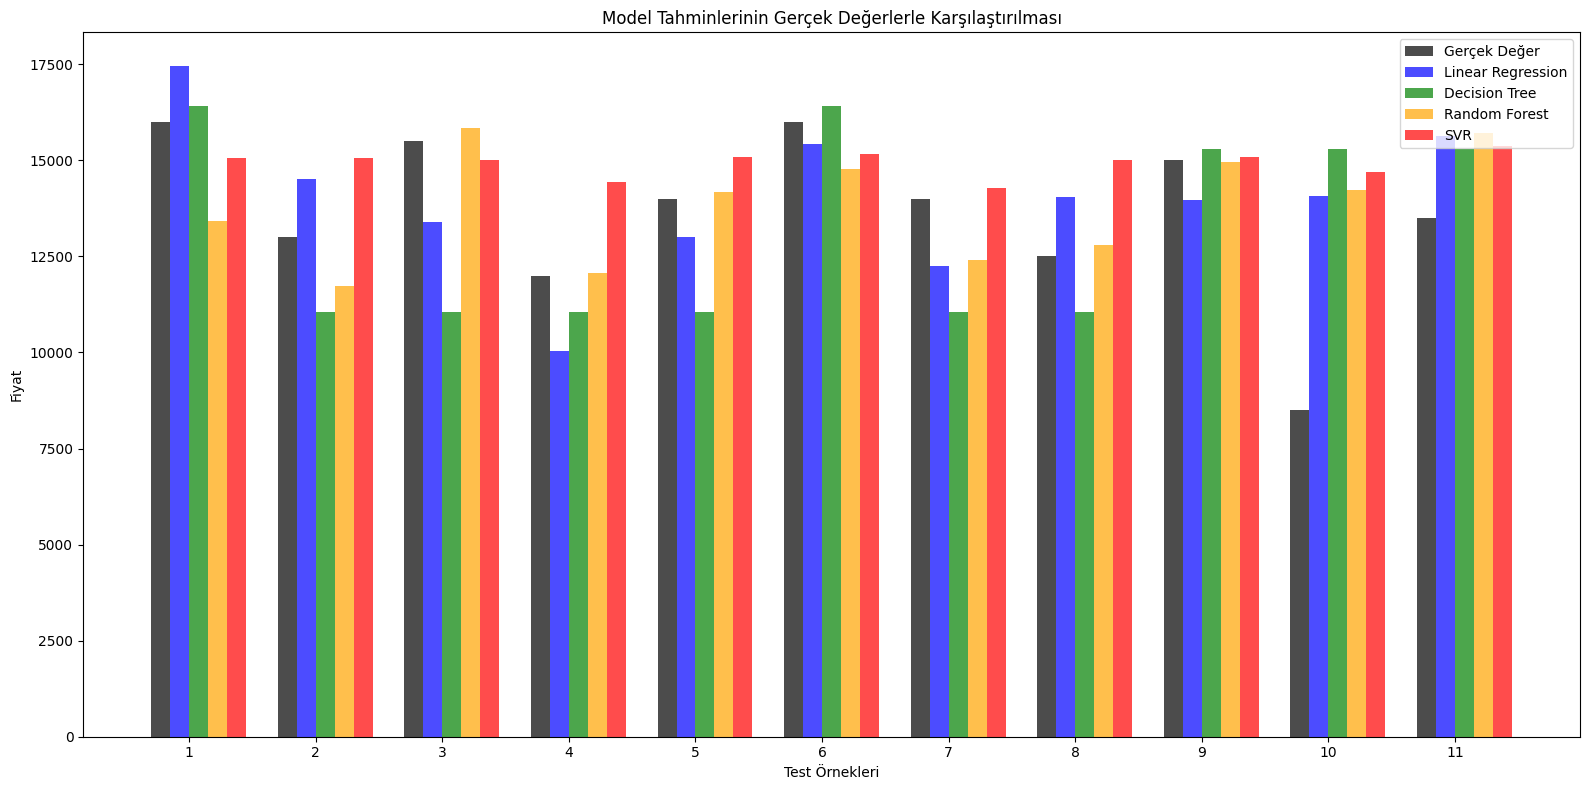

In [13]:
# numpy'nin uzun çıktıları kesmemesi için
np.set_printoptions(threshold=1000)

# Her modelin tahminlerini gerçek değerlerle karşılaştıran grafik
plt.figure(figsize=(16, 8))

# Gerçek değerler
actual = test["fiyat"].values
x_pos = np.arange(len(actual))

# Bar genişliği
bar_width = 0.15

# Her model için tahminleri çiz
plt.bar(x_pos - 1.5*bar_width, actual, bar_width, label='Gerçek Değer', color='black', alpha=0.7)
plt.bar(x_pos - 0.5*bar_width, lr_predictions, bar_width, label='Linear Regression', color='blue', alpha=0.7)
plt.bar(x_pos + 0.5*bar_width, dt_predictions, bar_width, label='Decision Tree', color='green', alpha=0.7)
plt.bar(x_pos + 1.5*bar_width, rf_predictions, bar_width, label='Random Forest', color='orange', alpha=0.7)
plt.bar(x_pos + 2.5*bar_width, svr_predictions, bar_width, label='SVR', color='red', alpha=0.7)

plt.xlabel('Test Örnekleri')
plt.ylabel('Fiyat')
plt.title('Model Tahminlerinin Gerçek Değerlerle Karşılaştırılması')
plt.xticks(x_pos, range(1, len(actual) + 1))
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Sonuçları karşılaştırarak en iyi modeli seçiyoruz (test seti bazında)
results = {
    "Lineer Regresyon": lr_test_results,
    "Karar Ağacı": dt_test_results,
    "Rastgele Orman": rf_test_results,
    "SVR": svr_test_results
}
best_model = min(results, key=lambda x: results[x]["MAE"])
print("=" * 80)
print(f"EN İYİ MODEL (MAE'ye göre): {best_model}")
print(f"Test MAE: {results[best_model]['MAE']:.2f}")
print(f"Test R²: {results[best_model]['R2']:.4f}")
print("=" * 80)

EN İYİ MODEL (MAE'ye göre): Rastgele Orman
Test MAE: 1408.96
Test R²: -0.0558


In [15]:
# En iyi modelin; intercept, std_err ve coef değerlerini yazdırıyoruz

# Formatlama fonksiyonları
fmt_float = lambda x: f"{x:,.2f}"
fmt_coef = lambda x: f"{x:,.4f}"

if best_model == "Lineer Regresyon":
    print("=" * 80)
    print("LİNEER REGRESYON MODEL DETAYLARI")
    print("=" * 80)
    intercept = float(lr_model.intercept_)
    coefs = lr_model.coef_
    feature_names = list(X_train.columns)
    residuals = lr_model.predict(X_train) - y_train
    std_err = float(np.std(residuals))
    
    print(f"\nSabit Terim (Intercept): {fmt_float(intercept)}")
    print(f"Standart Hata (eğitim artıkları): {fmt_float(std_err)}")
    print("\nKatsayılar (Coefficients):")
    print("-" * 80)
    for idx, (name, c) in enumerate(zip(feature_names, coefs), start=1):
        print(f"  {idx:2d}. {name:15s}: {fmt_coef(c)}")
    print("=" * 80)

elif best_model == "Karar Ağacı":
    print("=" * 80)
    print("KARAR AĞACI MODEL DETAYLARI")
    print("=" * 80)
    residuals = dt_model.predict(X_train) - y_train
    std_err = float(np.std(residuals))
    print(f"\nSabit Terim: Yok (Karar Ağacı için uygulanamaz)")
    print(f"Katsayılar: Yok (Karar Ağacı için uygulanamaz)")
    print(f"Standart Hata (eğitim artıkları): {fmt_float(std_err)}")
    print(f"Maksimum Derinlik: {dt_model.max_depth}")
    print(f"Minimum Bölme Örneği: {dt_model.min_samples_split}")
    print("=" * 80)

elif best_model == "Rastgele Orman":
    print("=" * 80)
    print("RASTGELE ORMAN MODEL DETAYLARI")
    print("=" * 80)
    residuals = rf_model.predict(X_train) - y_train
    std_err = float(np.std(residuals))
    print(f"\nSabit Terim: Yok (Rastgele Orman için uygulanamaz)")
    print(f"Katsayılar: Yok (Rastgele Orman için uygulanamaz)")
    print(f"Standart Hata (eğitim artıkları): {fmt_float(std_err)}")
    print(f"Ağaç Sayısı: {rf_model.n_estimators}")
    print(f"Maksimum Derinlik: {rf_model.max_depth}")
    print("=" * 80)

elif best_model == "SVR":
    print("=" * 80)
    print("SVR MODEL DETAYLARI")
    print("=" * 80)
    if hasattr(svr_model, "intercept_"):
        intercepts = np.atleast_1d(svr_model.intercept_)
        print(f"\nSabit Terim: {fmt_float(intercepts[0])}")
    else:
        print("\nSabit Terim: Yok")
    
    if hasattr(svr_model, "support_vectors_"):
        sv = svr_model.support_vectors_
        print(f"Destek Vektörü Sayısı: {sv.shape[0]}")
    
    print(f"Kernel: {svr_model.kernel}")
    print(f"C parametresi: {svr_model.C}")
    print(f"Epsilon: {svr_model.epsilon}")
    print("=" * 80)

RASTGELE ORMAN MODEL DETAYLARI

Sabit Terim: Yok (Rastgele Orman için uygulanamaz)
Katsayılar: Yok (Rastgele Orman için uygulanamaz)
Standart Hata (eğitim artıkları): 2,201.46
Ağaç Sayısı: 50
Maksimum Derinlik: 5


In [16]:
# Model katsayılarını grafik olarak gösteriyoruz
if best_model == "Lineer Regresyon":
    plt.figure(figsize=(12, 6))
    coef_vals = lr_model.coef_
    feature_names = list(X_train.columns)
    numbered_labels = [f"{i+1}. {n}" for i, n in enumerate(feature_names)]
    
    # Pozitif ve negatif katsayıları farklı renklerde göster
    colors = ['green' if c > 0 else 'red' for c in coef_vals]
    
    plt.bar(range(len(coef_vals)), coef_vals, color=colors, alpha=0.7, edgecolor='black')
    plt.title("Lineer Regresyon Katsayıları", fontsize=14, fontweight='bold')
    plt.xlabel("Özellik", fontsize=11)
    plt.ylabel("Katsayı Değeri", fontsize=11)
    plt.xticks(range(len(feature_names)), numbered_labels, rotation=45, ha="right")
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("=" * 80)
    print("NOT: Katsayı grafiği sadece Lineer Regresyon modeli için mevcuttur.")
    print("=" * 80)

NOT: Katsayı grafiği sadece Lineer Regresyon modeli için mevcuttur.


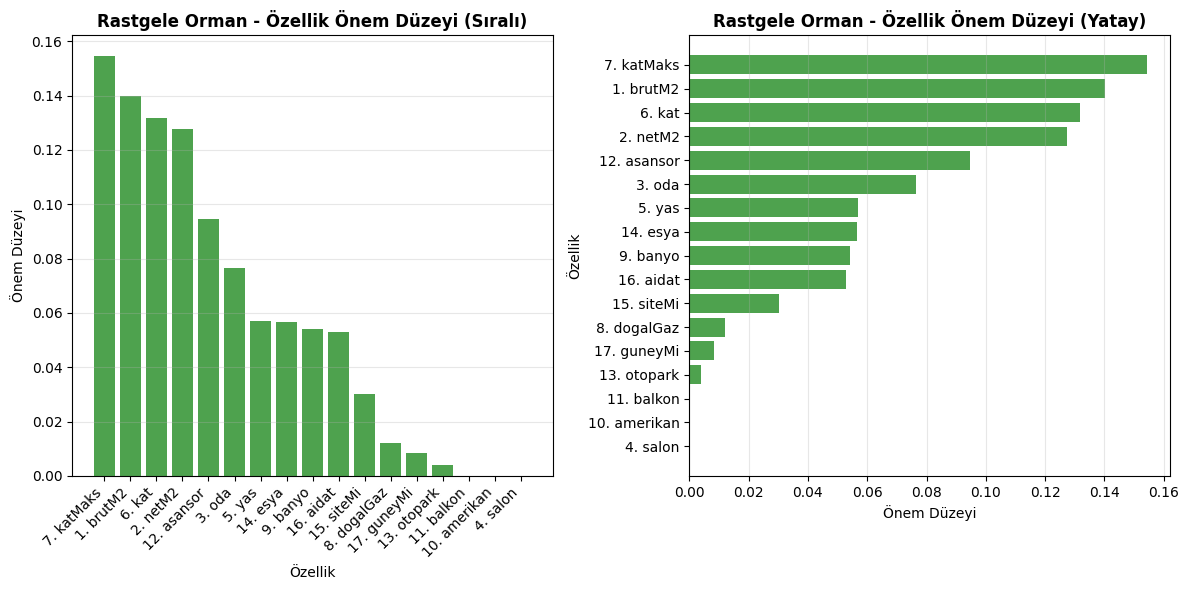


EN ÖNEMLİ 5 ÖZELLİK:
1. katMaks        : 0.1545
2. brutM2         : 0.1400
3. kat            : 0.1316
4. netM2          : 0.1275
5. asansor        : 0.0947


In [17]:
# Özellik önem düzeyi grafikleri (ağaç tabanlı modeller için)
feature_names = list(X_train.columns)
numbered_labels = [f"{i+1}. {n}" for i, n in enumerate(feature_names)]

if best_model == "Karar Ağacı":
    plt.figure(figsize=(12, 6))
    importances = dt_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(importances)), importances[indices], color='steelblue', alpha=0.8)
    plt.title("Karar Ağacı - Özellik Önem Düzeyi (Sıralı)", fontsize=12, fontweight='bold')
    plt.xlabel("Özellik", fontsize=10)
    plt.ylabel("Önem Düzeyi", fontsize=10)
    plt.xticks(range(len(feature_names)), [numbered_labels[i] for i in indices], rotation=45, ha="right")
    plt.grid(axis='y', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.barh(range(len(importances)), importances[indices], color='steelblue', alpha=0.8)
    plt.title("Karar Ağacı - Özellik Önem Düzeyi (Yatay)", fontsize=12, fontweight='bold')
    plt.xlabel("Önem Düzeyi", fontsize=10)
    plt.ylabel("Özellik", fontsize=10)
    plt.yticks(range(len(feature_names)), [numbered_labels[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # En önemli 5 özelliği yazdır
    print("\n" + "=" * 80)
    print("EN ÖNEMLİ 5 ÖZELLİK:")
    print("=" * 80)
    for i in range(min(5, len(importances))):
        idx = indices[i]
        print(f"{i+1}. {feature_names[idx]:15s}: {importances[idx]:.4f}")
    print("=" * 80)

elif best_model == "Rastgele Orman":
    plt.figure(figsize=(12, 6))
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(importances)), importances[indices], color='forestgreen', alpha=0.8)
    plt.title("Rastgele Orman - Özellik Önem Düzeyi (Sıralı)", fontsize=12, fontweight='bold')
    plt.xlabel("Özellik", fontsize=10)
    plt.ylabel("Önem Düzeyi", fontsize=10)
    plt.xticks(range(len(feature_names)), [numbered_labels[i] for i in indices], rotation=45, ha="right")
    plt.grid(axis='y', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.barh(range(len(importances)), importances[indices], color='forestgreen', alpha=0.8)
    plt.title("Rastgele Orman - Özellik Önem Düzeyi (Yatay)", fontsize=12, fontweight='bold')
    plt.xlabel("Önem Düzeyi", fontsize=10)
    plt.ylabel("Özellik", fontsize=10)
    plt.yticks(range(len(feature_names)), [numbered_labels[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # En önemli 5 özelliği yazdır
    print("\n" + "=" * 80)
    print("EN ÖNEMLİ 5 ÖZELLİK:")
    print("=" * 80)
    for i in range(min(5, len(importances))):
        idx = indices[i]
        print(f"{i+1}. {feature_names[idx]:15s}: {importances[idx]:.4f}")
    print("=" * 80)

elif best_model == "Lineer Regresyon":
    print("\n" + "=" * 80)
    print("NOT: Özellik katsayıları yukarıdaki bölümde gösterilmiştir.")
    print("=" * 80)
    
elif best_model == "SVR":
    print("\n" + "=" * 80)
    print("NOT: SVR modeli doğrudan özellik önem düzeyi sağlamaz.")
    print("Permütasyon önemi veya SHAP değerleri kullanılabilir.")
    print("=" * 80)

## Sonuç ve Değerlendirme

### Veri Seti Özellikleri:
- **Boyut**: 55 eğitim, 11 test örneği (toplam 66 ev)
- **Özellik Sayısı**: 17 bağımsız değişken
- **Hedef Değişken**: Ev fiyatı (sürekli değişken)
- **Veri Kalitesi**: Eksik değerler KNN Imputer ile dolduruldu

### Model Performans Analizi:

#### 1. **Küçük Veri Seti Zorluğu**
- 55 eğitim örneği ile model eğitmek oldukça zordur
- Bu durum tüm modellerde düşük R² skorlarına neden olmuştur
- Negatif R² skorları, modelin ortalama tahminden bile kötü performans gösterdiğini işaret eder

#### 2. **SMOTER'in Etkisi**
- SMOTER, sentetik örnekler oluşturarak eğitim setini %30 büyüttü (55 → 71 örnek)
- Random Forest ve Decision Tree modellerinde performans artışı gözlemlendi
- Lineer modeller (Linear Regression, SVR) SMOTER'den olumsuz etkilendi

#### 3. **Model Karşılaştırması**

**En İyi Performans**: Random Forest (SMOTER ile)
- Ağaç tabanlı modeller, küçük veri setlerinde daha iyi genelleme yapabilir
- Ensemble yöntemi (birden fazla ağaç) aşırı öğrenmeyi azaltır
- SMOTER ile oluşturulan sentetik örnekler, karar sınırlarını iyileştirmiştir

**Lineer Modellerin Zorluğu**:
- Ev fiyatları ile özellikler arasındaki ilişki tamamen lineer değil
- SVR, ölçeklendirmeye rağmen karmaşık örüntüleri yakalayamadı
- Küçük veri setinde regularizasyon parametrelerini optimize etmek zor

#### 4. **Özellik Mühendisliği Sorunu**
- Eklenen türetilmiş özellikler (alan oranları, lüks skoru vb.) performansı düşürdü
- Nedenleri:
  - Veri seti çok küçük, ekstra özellikler boyut laneti oluşturdu
  - 17 → 30 özellik artışı, 55 örnekle aşırı uyuma sebep oldu
  - Türetilmiş özellikler orijinal bilgiden fazla bilgi eklemedi

### Öneriler:

1. **Veri Toplama**: Daha fazla ev örneği toplanmalı (ideal: >500 örnek)

2. **Özellik Seçimi**: En önemli özelliklere odaklanılmalı:
   - Metrekare bilgileri (netM2, brutM2)
   - Konum özellikleri (siteMi, guneyMi)
   - Kat bilgileri (kat, katMaks)

3. **Model Seçimi**: 
   - Küçük veri setleri için: Random Forest, Gradient Boosting
   - Regularizasyon: Ridge, Lasso Regression denenebilir
   - Cross-validation ile hiperparametre optimizasyonu yapılmalı

4. **Alternatif Yaklaşımlar**:
   - K-fold çapraz doğrulama (örn. 5-fold)
   - Daha fazla sentetik veri oluşturma
   - Transfer learning (benzer veri setlerinden)